# Model Training

In [12]:
import pandas as pd
import ast
import warnings
import os
warnings.filterwarnings("ignore")
import sys
sys.path.append("../")
from utils.machine_learning import DataPreprocess, ModelTraining, MetricsVisualizations, compare_confusion_matrices

In [13]:
preprocess = DataPreprocess()
trainer = ModelTraining()

# Data

In [14]:
df = pd.read_csv("./Data/model_training_payments.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (77414, 13)


,VALOR_A_PAGAR,TAXA,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,INADIMPLENTE,month_vencimento,days_until_due,days_since_registration
0,35516.41,6.99,Nordeste,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0,9,36,1821
1,17758.21,6.99,Nordeste,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0,9,40,1823
2,17431.96,6.99,Nordeste,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0,9,47,1830
3,1341.00,6.99,Nordeste,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,1,10,65,1834
4,21309.85,6.99,Nordeste,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0,9,50,1835


# Preprocessing the Data

### Based on the information gathered during **Feature Engineering**:
- `VALOR_A_PAGAR`, `RENDA_MES_ANTERIOR`, `days_until_due` = Cubic Root Transformation
- `NO_FUNCIONARIOS`, `days_since_registration` = No transformation needed

### For the preprocess step, the data will be divided into a train and test split. The numerical columns will be transformed using the log and cubic transformations, and then they will be scaled using the Robust Scaler in reason of the outliers and because `TAXA` and `month_vencimento` columns won't go through the statistical transformation step. Also, onehot encoding will be performed on the categorical columns of the dataset. The preprocessor will be saved in the **Artifacts** folder
### Regarding the test dataset, the parameter **test_data** will be a flag to see if the data that is going to be preprocessed is the training or test one. Since in the test dataset the column `DATA_CADASTRO` has **Unknown** values, and this column was used together with `DATA_EMISSAO_DOCUMENTO` to create a new feature, the **Unknown** values of `DATA_CADASTRO` will be replaced with the values of `DATA_EMISSAO_DOCUMENTO`, so that the new feature `days_since_registration` has a value of **0** when `DATA_CADASTRO` was **Unknown**

In [15]:
X_train, X_test, y_train, y_test = preprocess.preprocess_data(df, target_name="INADIMPLENTE", test_size=0.3)

# Modeling

### For the modeling phase, three models will be used: Logistic Regression, Random Forest and Gradient Boosting.
### During each training and testing, two methods will be used to solve the imbalance issue of the target. The first one is using the parameter `class_weight` on the models that have it. The second method is the utilization of `SMOTE`, an oversampling method that uses synthetic data to balance the target. `SMOTE` will only be applied to the training sets, with the test sets having the original imbalance of the data
### After the models are trained and tested, they will be evaluated in terms of the metrics `Recall`, `Precision`, `f1` and `ROC-AUC`. `f1` and `Recall` are the most important metrics here, since the primary goal is to predict loan defaults. `Recall` will measure the proportion of true positives out of the actual positives, with a high recall consisting of a low number of false negatives. `Precision` will measure the proportion of positive predictions that are actually correct, with fewer false positives indicating a higher precision. `f1` will be the harmonic average between them, and ROC-AUC will evaluate the model's ability to discriminate the data between the two classes
### A high `Recall` is important, since a low number of false negatives indicates a low chance of losing a lot of money with defaulting clients. But this is useless if the precision is extremely low. Because of this, both `Recall` and `f1` will be the focus of the model training, each metric being the focus of a separate training. With this, a threshold analysis will be made to check whether changing the models threshold can improve its results
### To train the models, a repo in DagsHub will be used, along with MLflow to keep track of all the information about the models

# Focus on `Recall`

## Using class_weight = balanced

In [16]:
model_report_recall = trainer.initiate_model_trainer((X_train, y_train, X_test, y_test), "Focus on Recall", ["recall", "f1"], "recall")

2024/10/13 20:31:07 INFO mlflow.tracking.fluent: Experiment with name 'Focus on Recall' does not exist. Creating a new experiment.
2024/10/13 20:31:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression - Focus on Recall'.
2024/10/13 20:31:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Focus on Recall, version 1
Created version '1' of model 'Logistic Regression - Focus on Recall'.
2024/10/13 20:31:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/0/runs/a43e1a1b637549d0a5e062c35d424de4.
2024/10/13 20:31:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/vitorccmans

In [17]:
metrics_recall = MetricsVisualizations(model_report_recall)

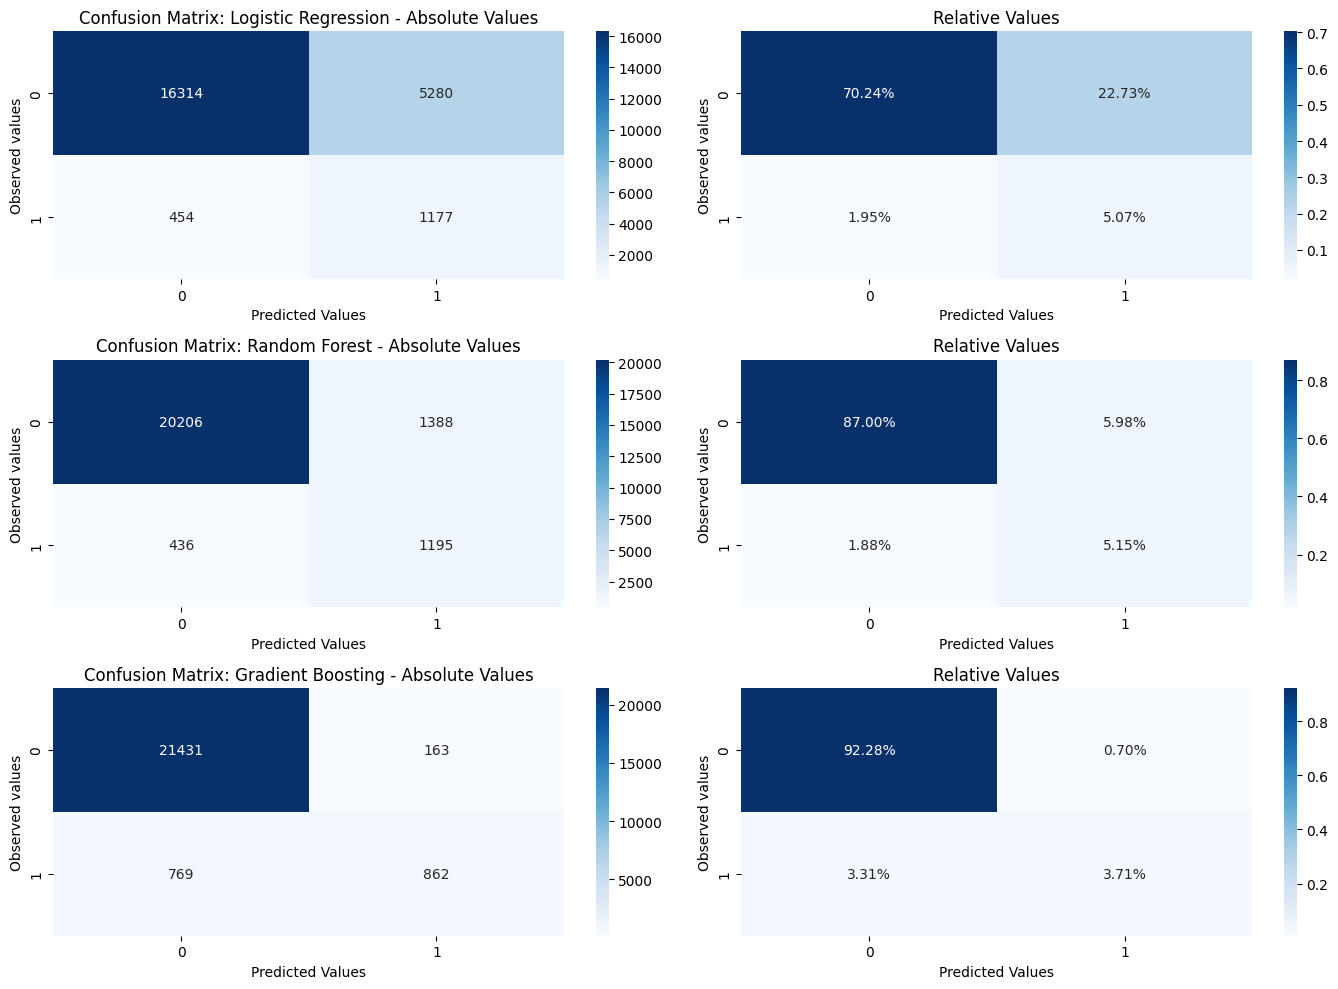

In [18]:
metrics_recall.visualize_confusion_matrix(y_test, 3, 2)

### Observations:
- The logistic regression model had a very high number of false positives, indicating that the model has very little `Precision`. Despite having a high `Recall`, the amount of false positives makes this model far from ideal
- The random forest model had a way lower number of false positives, with almost the same amount of false negatives, but the false positives is still high
- The gradient boosting model had a incredible `Precision`, but at a cost of a very low `Recall`

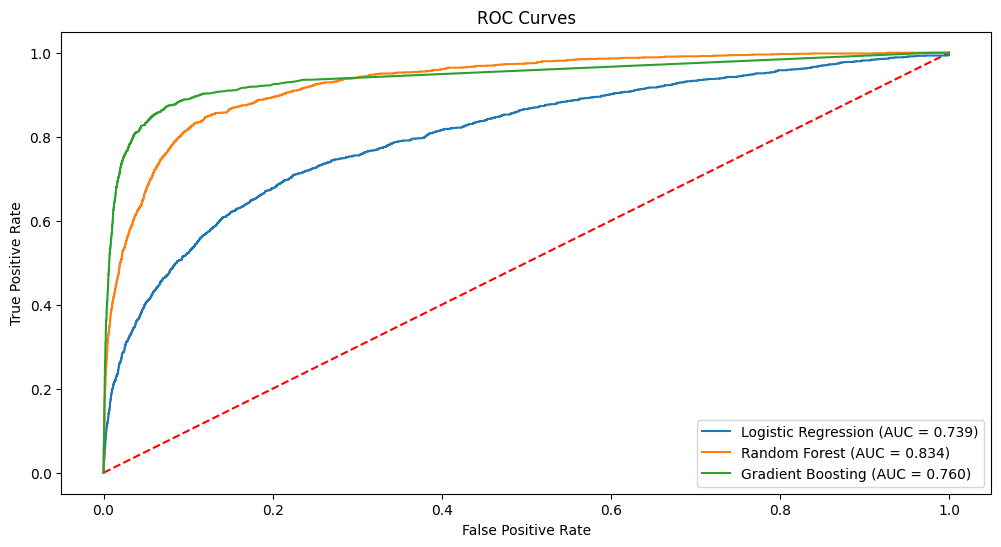

In [19]:
metrics_recall.visualize_roc_curves()

### Observations:
- The random forest model has the highest ROC-AUC scores, indicating that it's the best model at discriminating the data between both classes
- The logistic regression and gradient boosting models show a decent score, but it's very mediocre when compared to the random forest

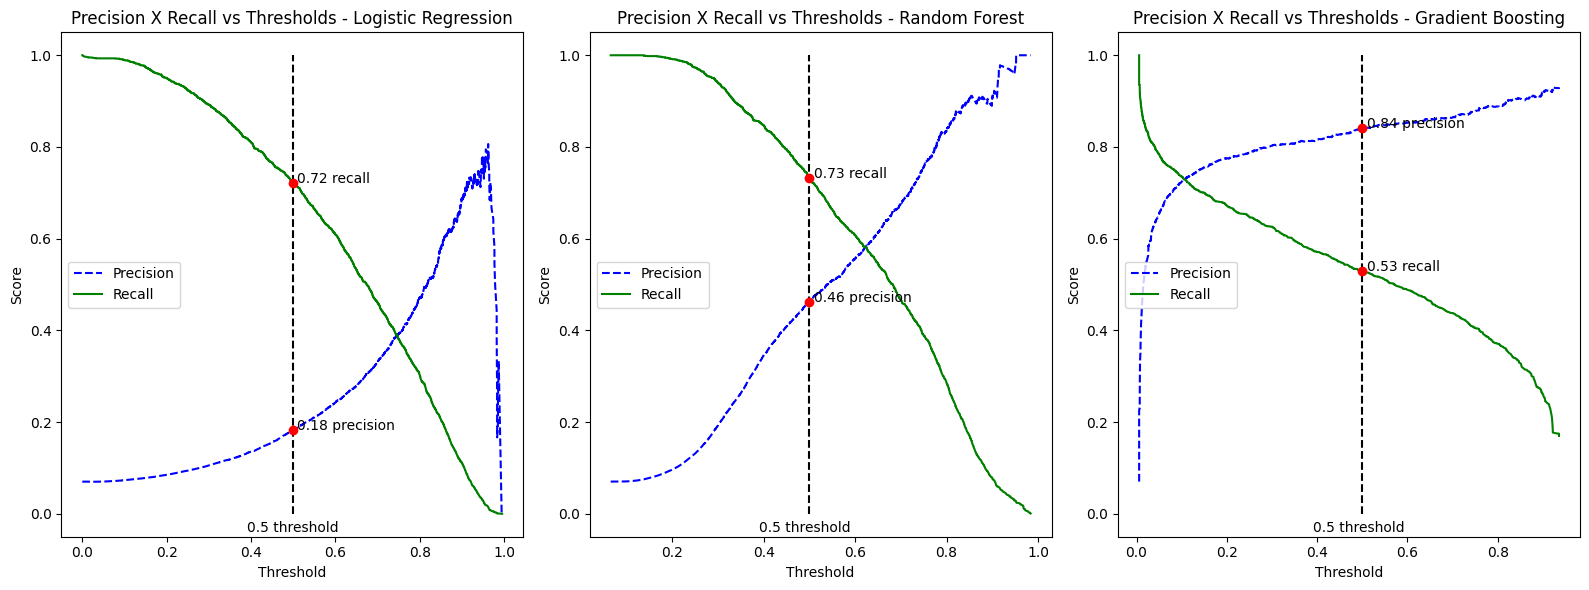

In [20]:
metrics_recall.plot_precision_recall_threshold(y_test, X_test, 1, 3)

### Observations:
- Logistic regression and random forest show that trying to perfect balance the `Recall` and `Precision` would result in a very big reduction of the `Recall` metric. This means that the models would have a lot more false negatives, increasing the amount of money spent
- Gradient boosting shows that it is possible to balance these metrics at around the 0.1 threshold, and it would be a small loss of `Precision`. Analyzing this model with this modified threshold may give very good results

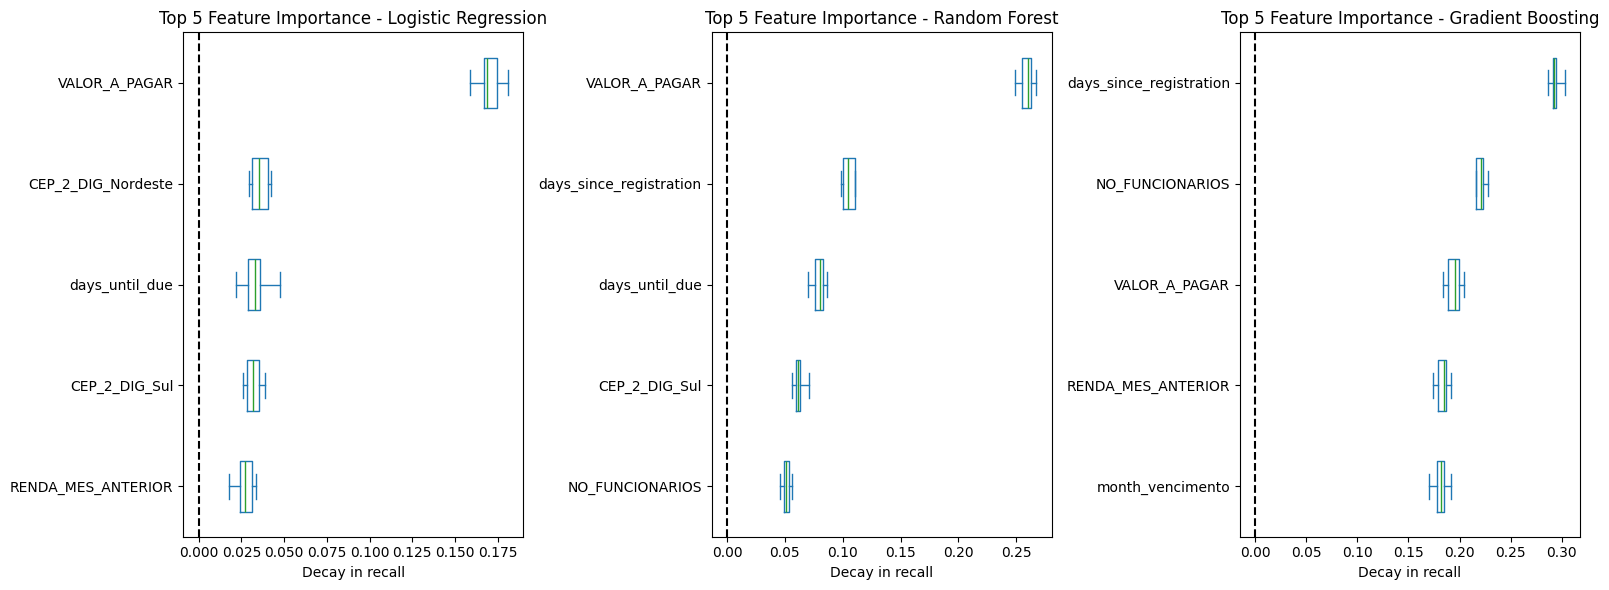

In [21]:
metrics_recall.plot_feature_importance(y_test, X_test, "recall", 1, 3)

### Observations:
- `VALOR_A_PAGAR` is by far the most important feature in both the logistic regression and random forest models
- For the gradient boosting model, the new feature `days_since_registration` was the most important one
- All models considered at least one of the new features at the top 5 most important ones

## Using SMOTE

In [22]:
model_report_recall_smote = trainer.initiate_model_trainer((X_train, y_train, X_test, y_test), "Focus on Recall", ["recall", "f1"], "recall", use_smote=True)

2024/10/13 20:55:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression - Focus on Recall' already exists. Creating a new version of this model...
2024/10/13 20:55:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Focus on Recall, version 2
Created version '2' of model 'Logistic Regression - Focus on Recall'.
2024/10/13 20:55:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/0/runs/9df58826b24243aba183d9e7831a1824.
2024/10/13 20:55:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/0.
2024/10/13 20:59:57 WARNING mlflow.models.

In [23]:
metrics_recall_smote = MetricsVisualizations(model_report_recall_smote)

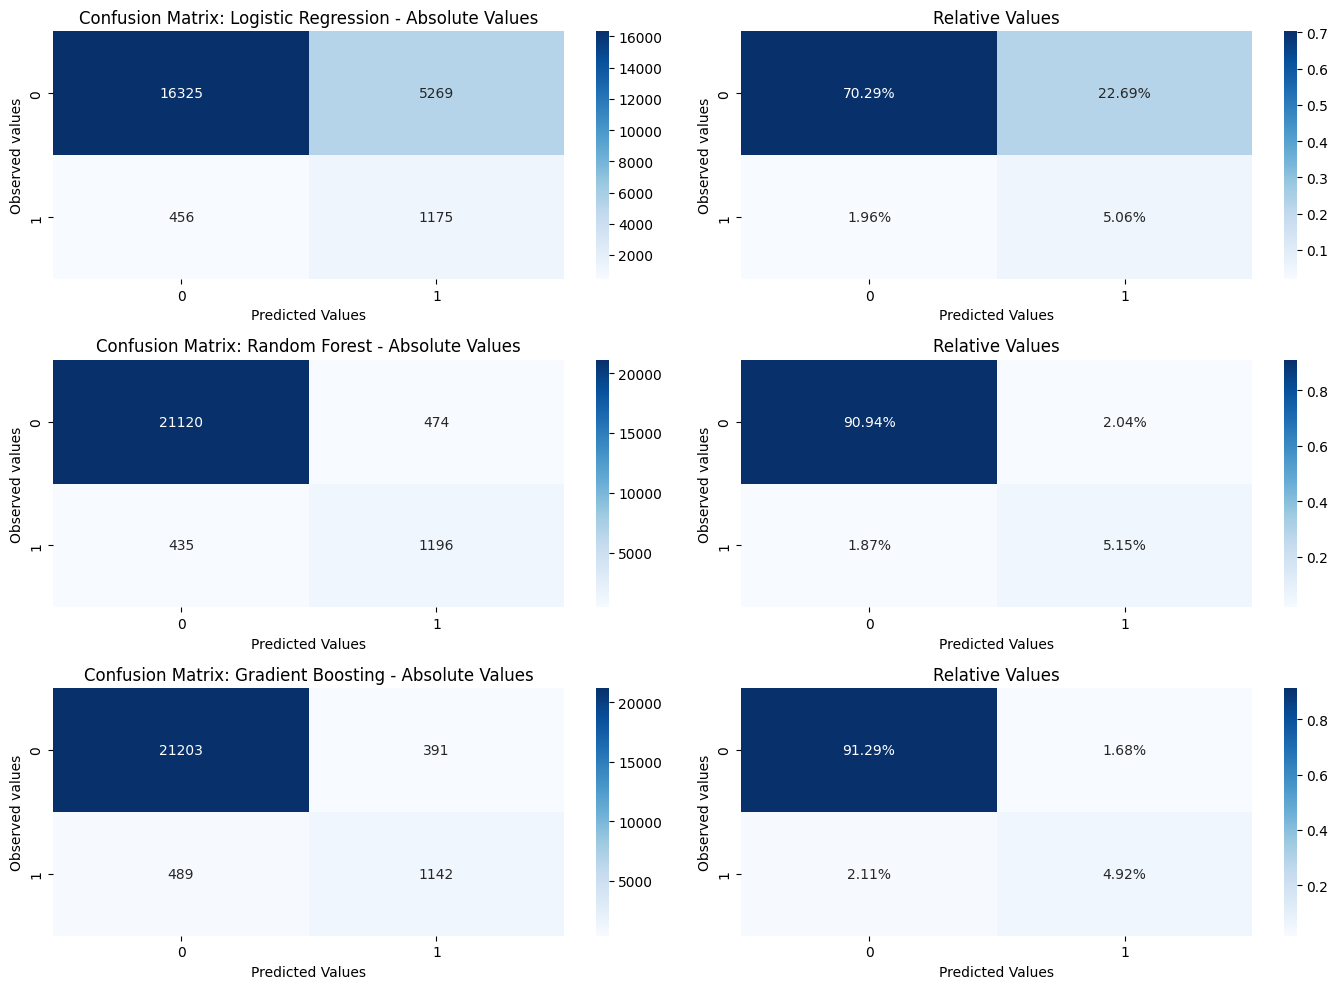

In [24]:
metrics_recall_smote.visualize_confusion_matrix(y_test, 3, 2)

### Observations:
- The logistic regression model showed the same performance
- Random forest had a major improvement. The model was able to keep a low number of false negatives but reduced the amount of false positives by almost three times
- Gradient boosting had an improvement in `Recall` but way worse `Precision`

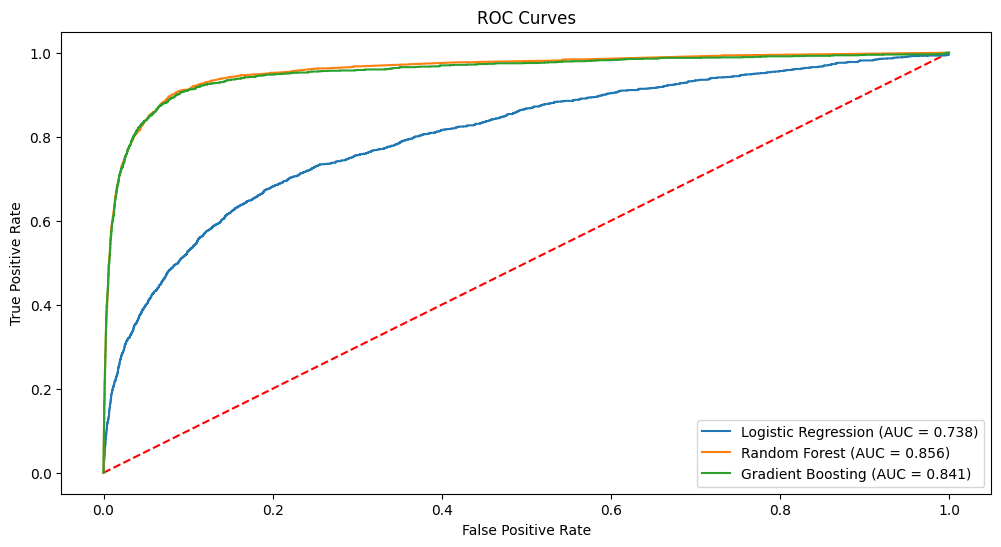

In [25]:
metrics_recall_smote.visualize_roc_curves()

### Observations:
- Logistic regression and random forest had the same performances
- Gradient boosting had a significant improvement, being almost as good as the random forest model in discriminating the data between both classes

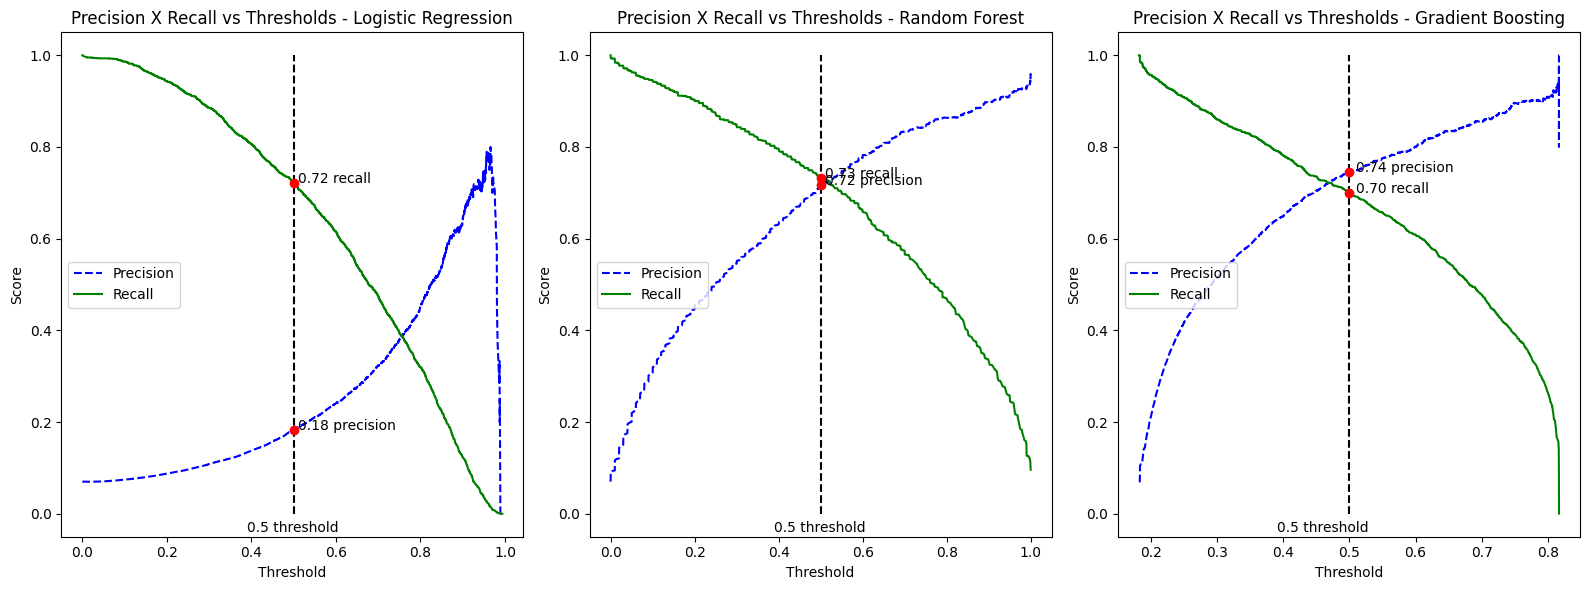

In [26]:
metrics_recall_smote.plot_precision_recall_threshold(y_test, X_test, 1, 3)

### Observations:
- Logistic regression had the same performance
- Random forest has a much higher `Precision`, almost tied with the `Recall`. Changing this model threshold would not be a good idea, since both metrics have a drastic fall off either by increasing or decreasing the threshold
- The same thing can be said about the gradient boosting, with the only difference being that the model now has a slightly lower `Precision`, but a way higher recall

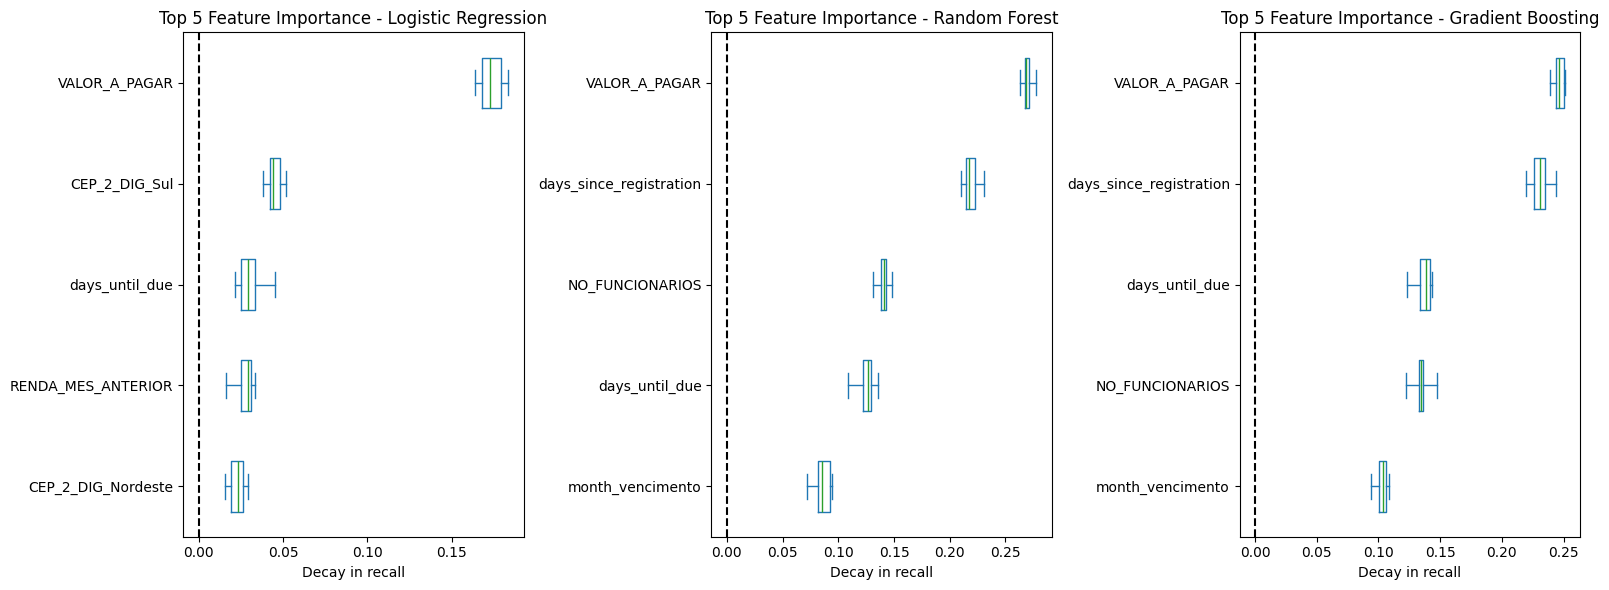

In [27]:
metrics_recall_smote.plot_feature_importance(y_test, X_test, "recall", 1, 3)

### Observations:
- `VALOR_A_PAGAR` is now the most important feature in all models
- On the best performing models, random forest and gradient boosting, all three new features were in the top 5 most important ones, with `days_since_registration` in second place, not far behind `VALOR_A_PAGAR`

# Focus on `f1`

## Using class_weight = balanced

In [28]:
model_report_f1 = trainer.initiate_model_trainer((X_train, y_train, X_test, y_test), "Focus on F1", ["f1", "recall"], "f1")

2024/10/13 22:02:49 INFO mlflow.tracking.fluent: Experiment with name 'Focus on F1' does not exist. Creating a new experiment.
2024/10/13 22:02:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Logistic Regression - Focus on F1'.
2024/10/13 22:03:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Focus on F1, version 1
Created version '1' of model 'Logistic Regression - Focus on F1'.
2024/10/13 22:03:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/1/runs/548a93b18e914543bdc9d4b71265f9b2.
2024/10/13 22:03:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/vitorccmanso/Defaulter_Pred

In [29]:
metrics_f1 = MetricsVisualizations(model_report_f1)

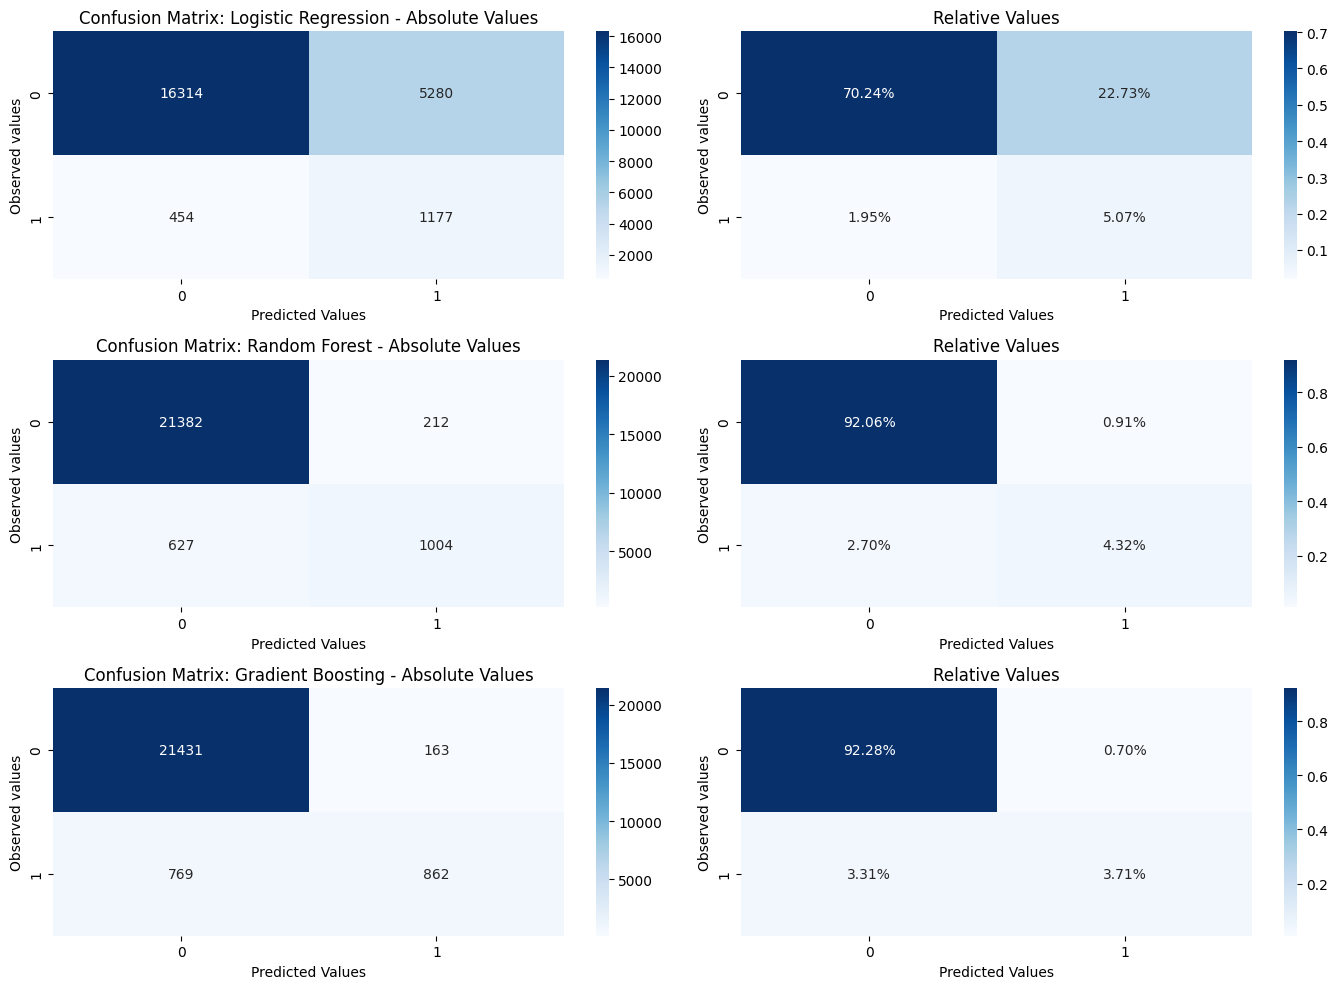

In [30]:
metrics_f1.visualize_confusion_matrix(y_test, 3, 2)

### Observations:
- Logistic regression and gradient boosting had the same performance as prioritizing `Recall`
- Random forest had a significant improvement in `Precision`, but a slightly lower `Recall`

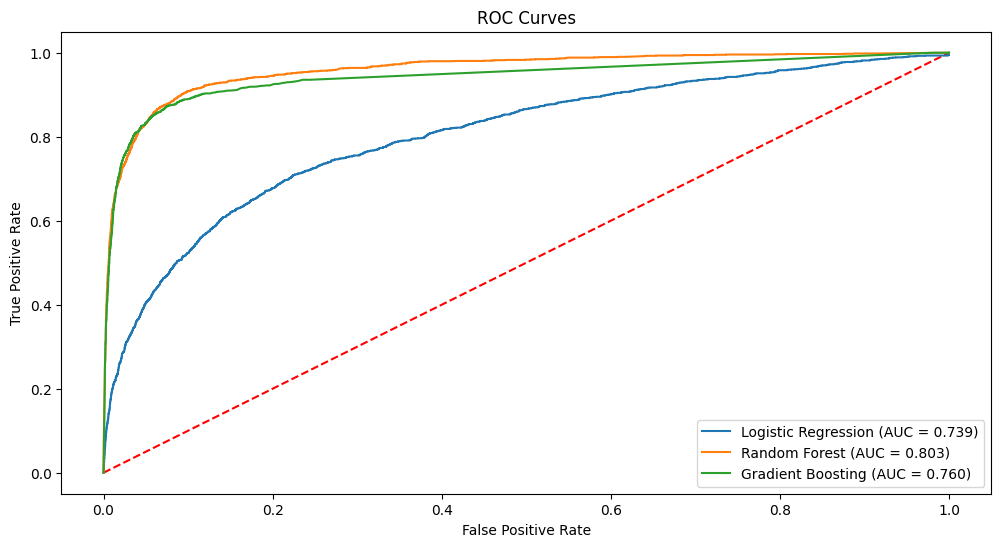

In [31]:
metrics_f1.visualize_roc_curves()

### Observations:
- Logistic regression and gradient boosting had the same performance
- Random forest continues to be the best model for discriminating the data between the classes

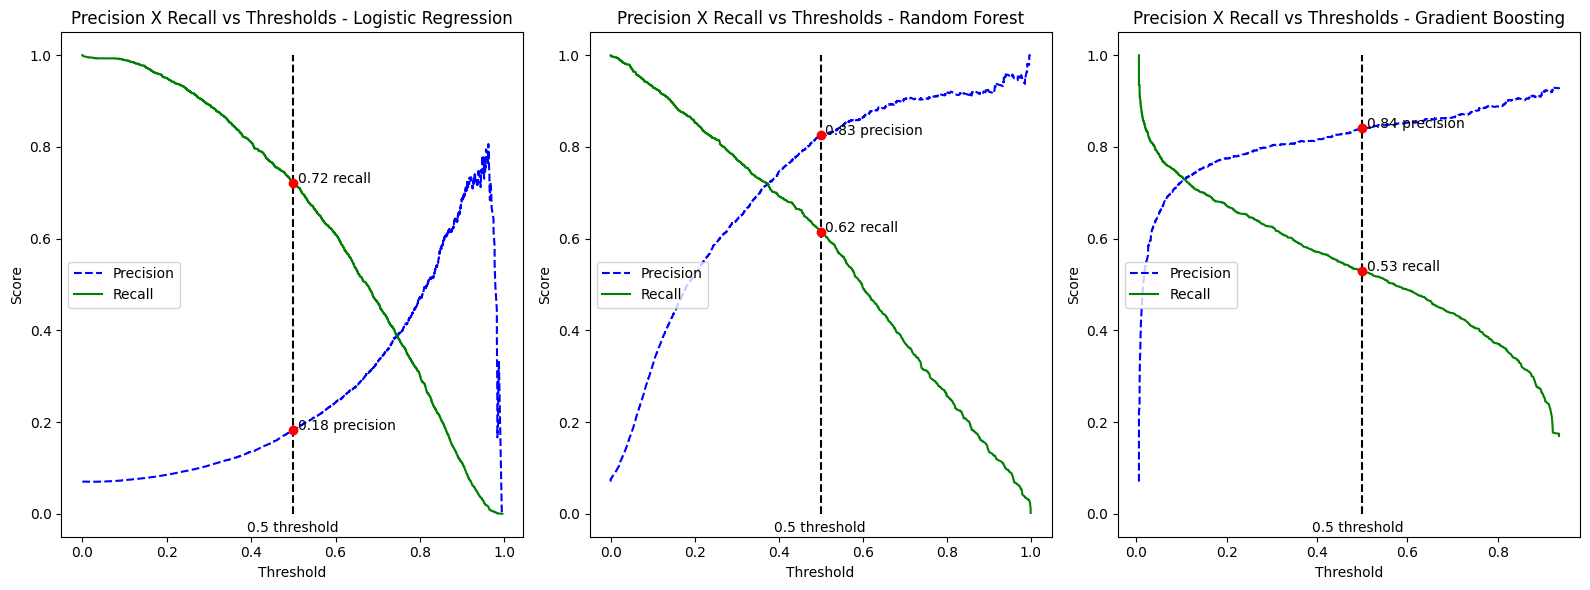

In [32]:
metrics_f1.plot_precision_recall_threshold(y_test, X_test, 1, 3)

### Observations:
- Logistic regression and gradient boosting had the same performance, with gradient boosting being a good model to perform a change in threshold
- Random forest had a very high `Precision` but a lower `Recall`. By changing the threshold to around 0.3, we can balance these metrics out, but any threshold lower than that, the `Precision` metric drops a lot

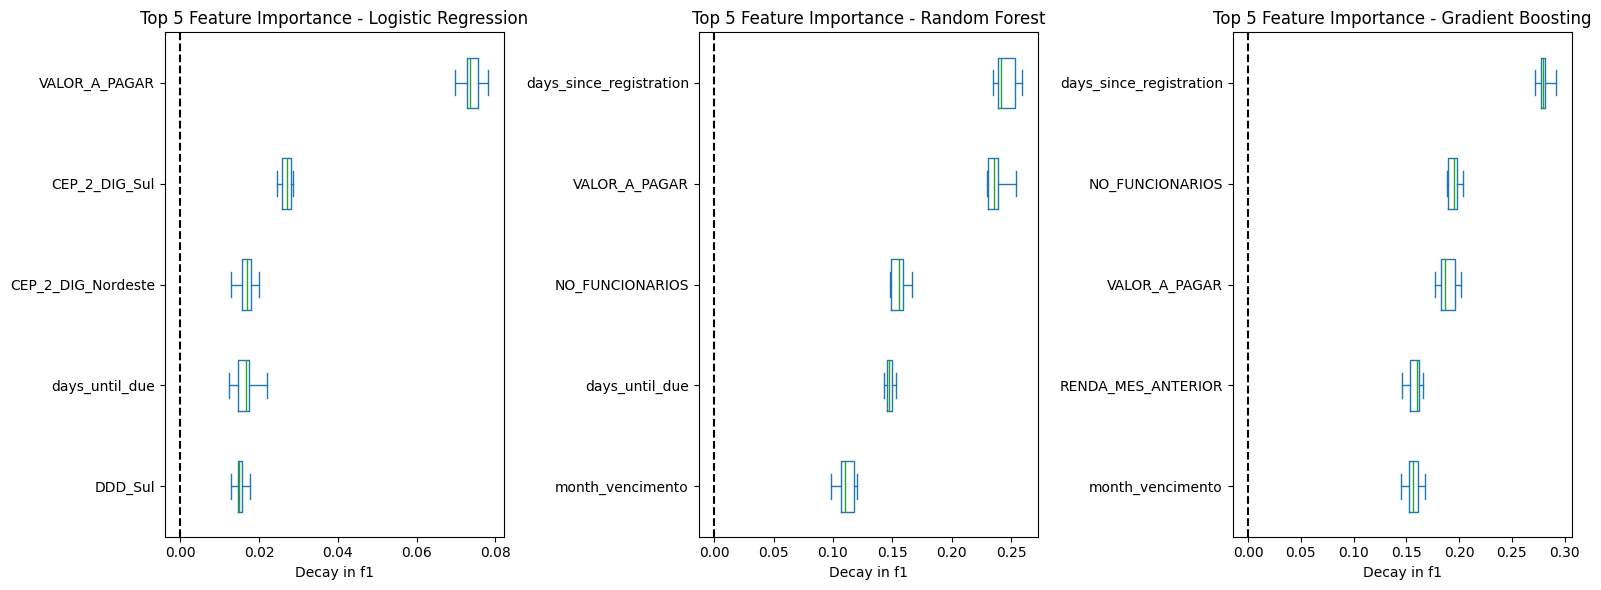

In [33]:
metrics_f1.plot_feature_importance(y_test, X_test, "f1", 1, 3)

### Observations:
- Logistic regression and gradient boosting had the same performance
- Random forest had `days_since_registration` as the most important feature, but it was basically a tie with `VALOR_A_PAGAR`. Also, the third and fourth most important features are tied. This model had all three new features in the top 5 most important ones

## Using SMOTE

In [34]:
model_report_f1_smote = trainer.initiate_model_trainer((X_train, y_train, X_test, y_test), "Focus on F1", ["f1", "recall"], "f1", use_smote=True)

2024/10/13 22:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression - Focus on F1' already exists. Creating a new version of this model...
2024/10/13 22:27:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Focus on F1, version 2
Created version '2' of model 'Logistic Regression - Focus on F1'.
2024/10/13 22:27:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/1/runs/42e1e872f43e40fd96a032c72f68fcdc.
2024/10/13 22:27:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/vitorccmanso/Defaulter_Prediction.mlflow/#/experiments/1.
2024/10/13 22:32:02 WARNING mlflow.models.model: Model

In [35]:
metrics_f1_smote = MetricsVisualizations(model_report_f1_smote)

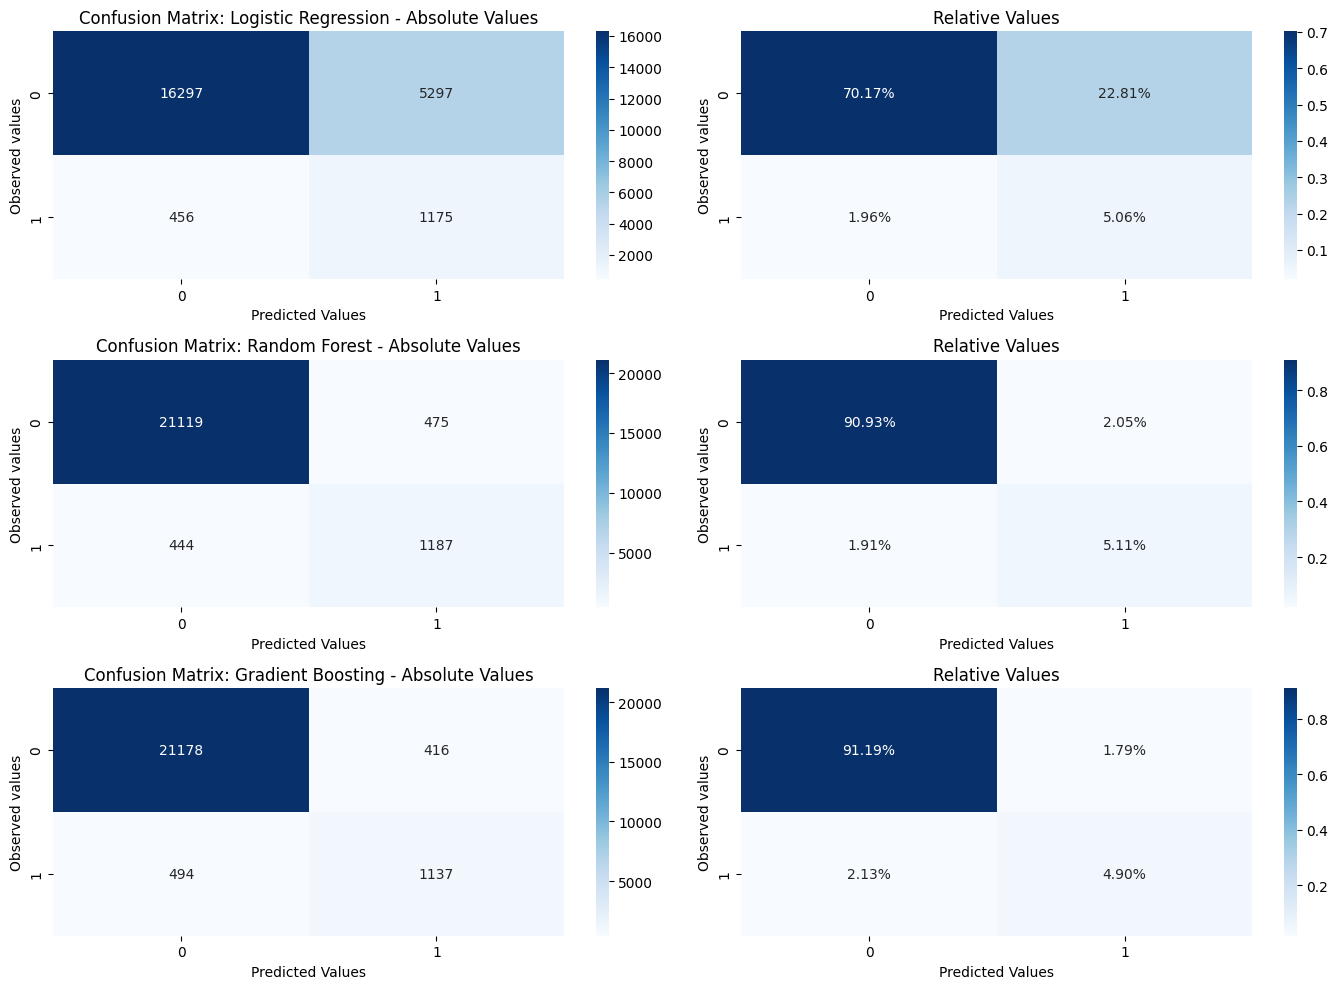

In [36]:
metrics_f1_smote.visualize_confusion_matrix(y_test, 3, 2)

### Observations:
- Logistic regression had basically the same performance as all other trainings
- Random forest had almost the same performance, with a few extra false negatives in comparison to using smote and prioritizing `Recall`
- The same thing can be said about the gradient boosting, but this time, there was a small increase in the number of false positives

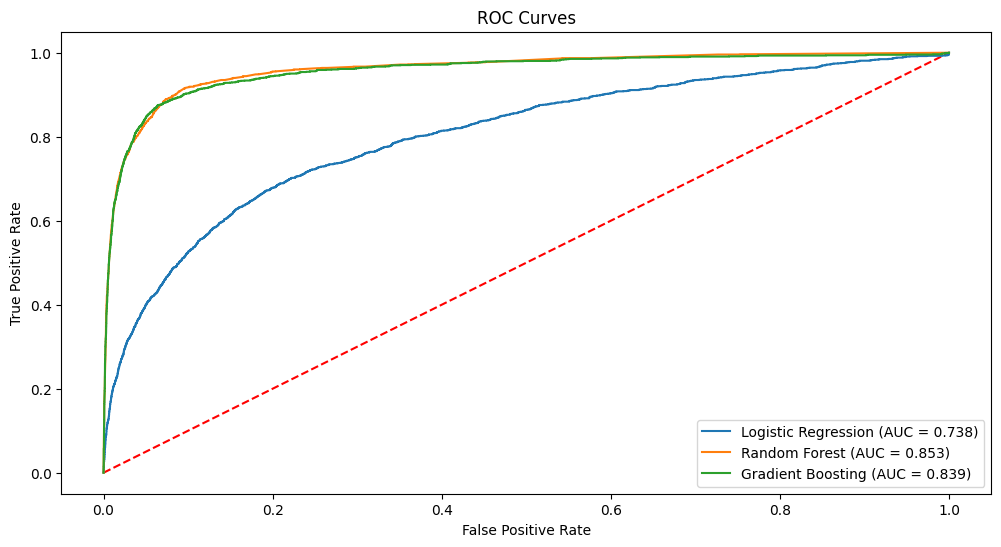

In [37]:
metrics_f1_smote.visualize_roc_curves()

### Observations:
- Random forest proves that is the best model overall in discriminating the data between both classes. It was the best model in this in all trainings

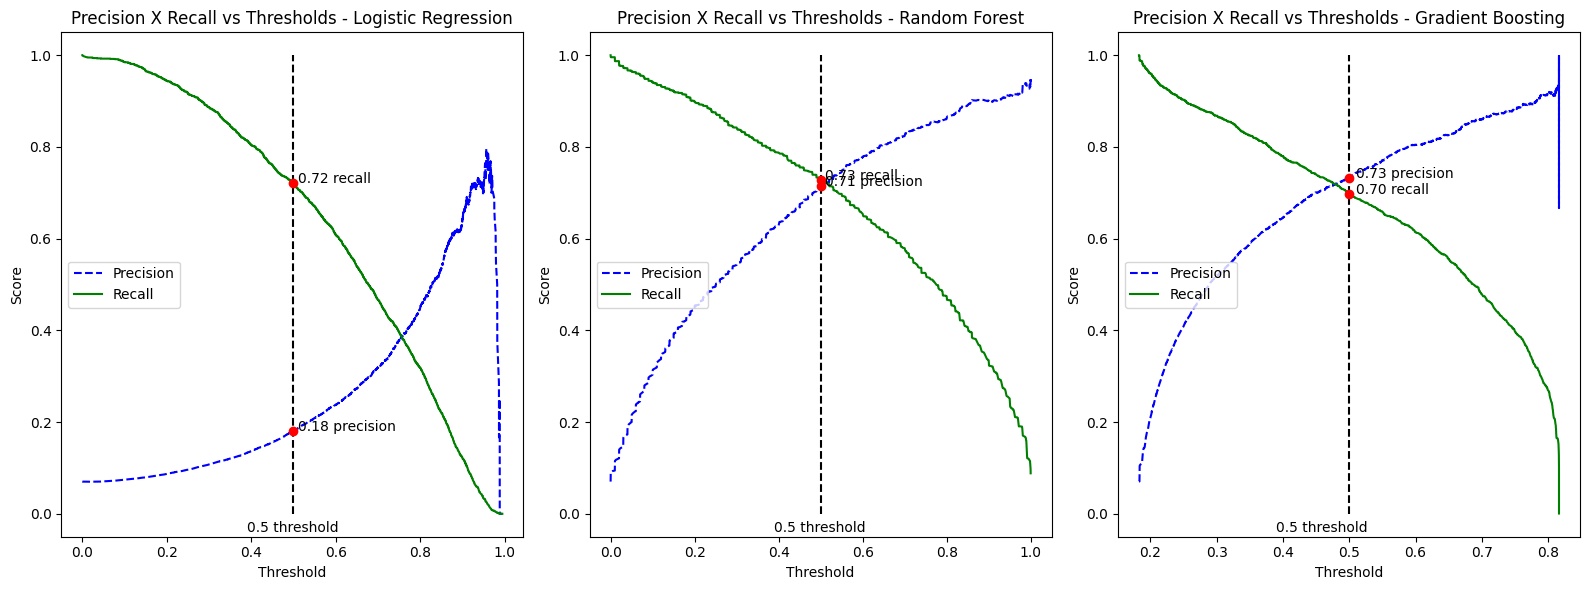

In [38]:
metrics_f1_smote.plot_precision_recall_threshold(y_test, X_test, 1, 3)

### Observations:
- All models had almost the same metrics as training with a focus on `Recall`

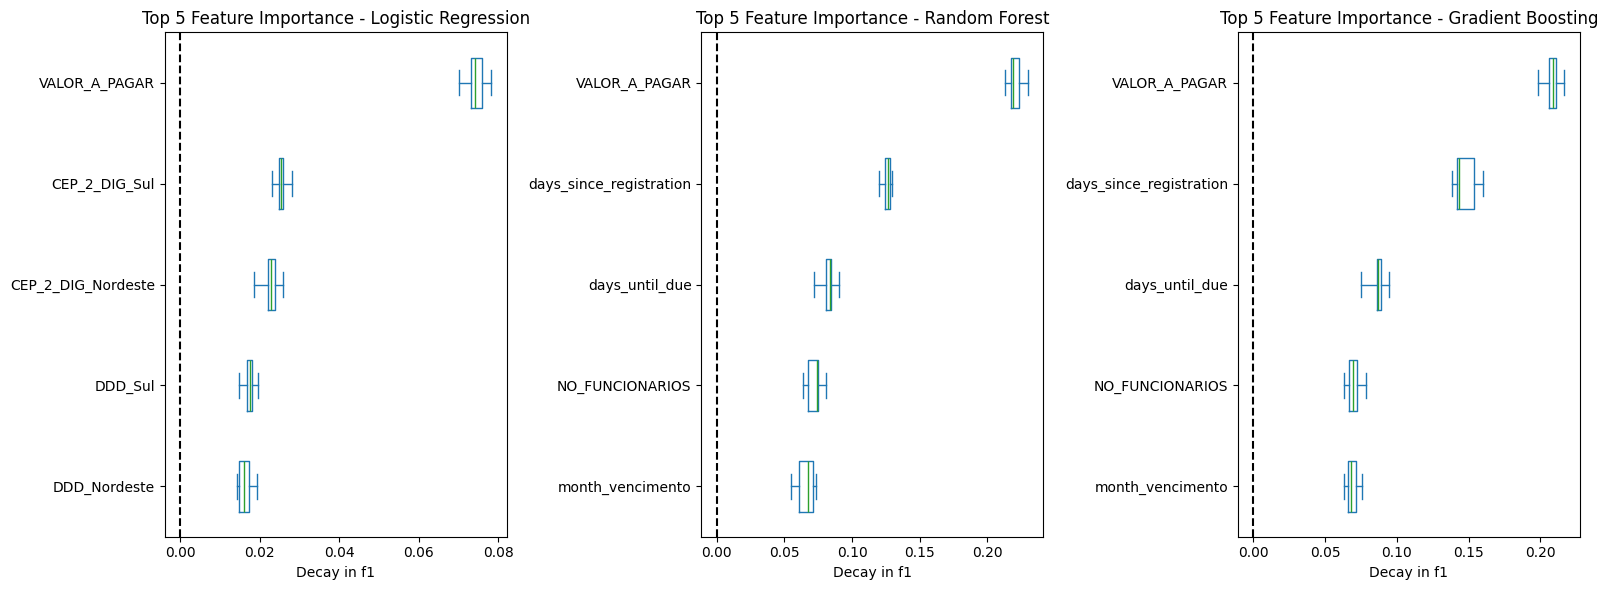

In [39]:
metrics_f1_smote.plot_feature_importance(y_test, X_test, "f1", 1, 3)

### Observations:
- Again `VALOR_A_PAGAR` is the most important feature, and again, all new features are in the top 5 most important ones

# Best models

### From these results, it's clear that the logistic regression model is not the best choice. It performed very badly in all trainings
### Between the random forest and the gradient boosting, it's possible to select a few models and draw some comparisons. The gradient boosting using the parameter `class_weight`and focusing on `Recall` shows that by altering its threshold (to about 0.1), it can be the best model. But the random forest and gradient boosting using `SMOTE`, with the random forest focusing on `Recall` and gradient boosting on `f1` had the lowest amount of errors (when combining false negatives and false positives), with an acceptable amount of false negatives and false positives
### The random forest model trained with `class_weight` and focusing on `f1` had the least amount of errors by almost 40, but since it has a very high number of false negatives, it failed to get a high number of true negatives, so it won't be in the discussion for what model to use
### With this, it's possible to draw the confusion matrices of these three best models with or without a different threshold to see what the results are

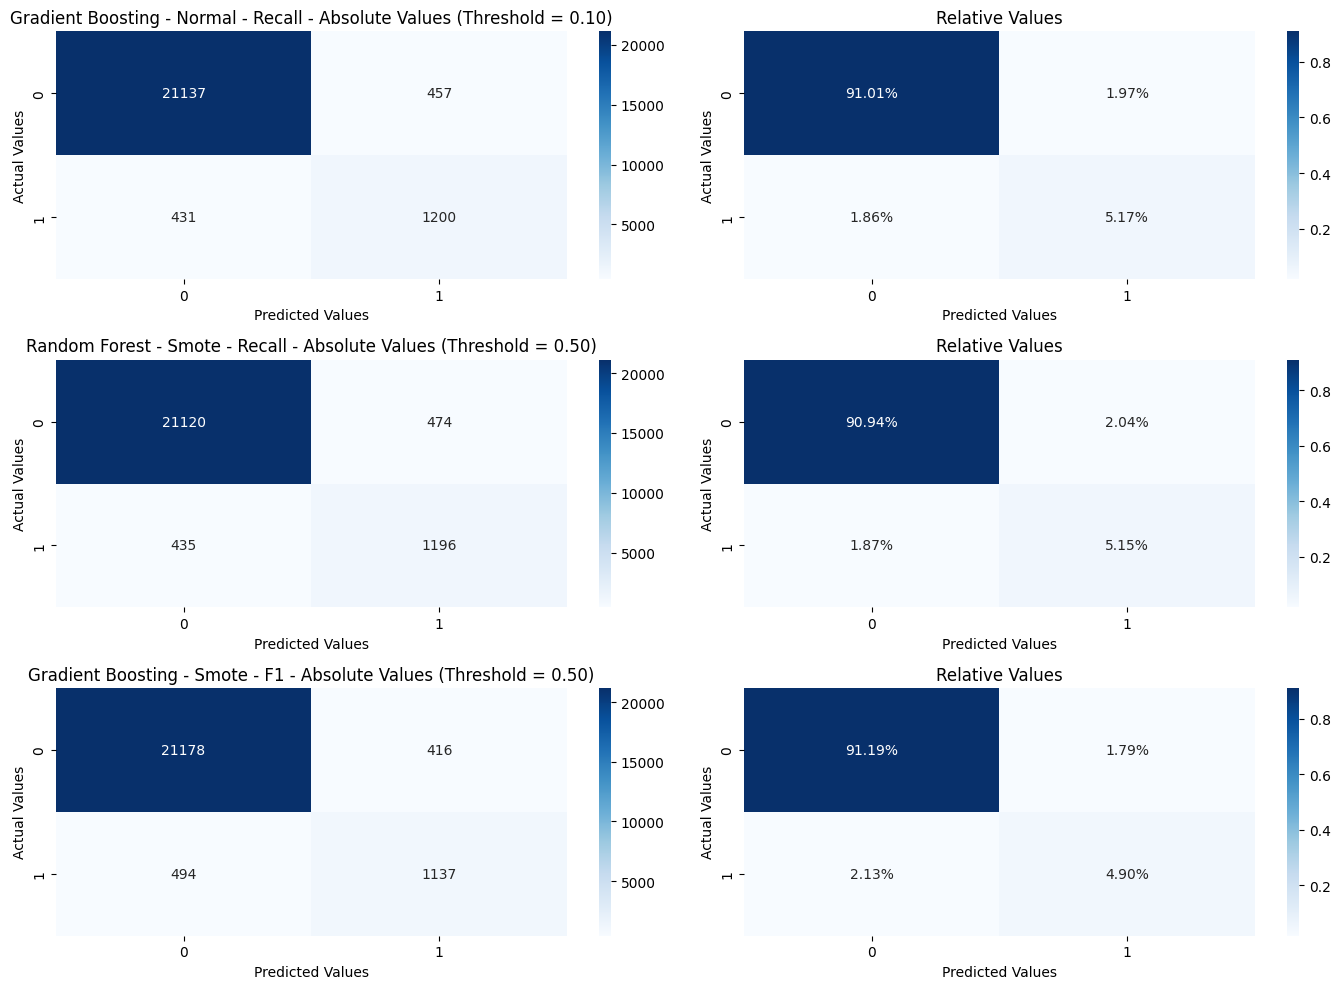

In [72]:
model_dicts_with_metrics = [(model_report_recall, "Normal", "Recall"), (model_report_recall_smote, "Smote", "Recall"), (model_report_f1_smote, "Smote", "F1")]
thresholds = {'Gradient Boosting - Normal - Recall': 0.1,
                'Random Forest - Smote - Recall': 0.5,
                'Gradient Boosting - Smote - F1': 0.5}
compare_confusion_matrices(y_test, X_test, model_dicts_with_metrics, thresholds, rows=3, columns=2)

# Conclusion
### As the image shows, the gradient boosting model with a threshold of 0.1 is the best one, but not by much. Assuming that it's more costly for the company emitting these loans to lend money to a defaulting client instead of not lending money to a non-defaulting one, the lower the false negatives, the better the model. Also, since the PDF for this project says that the final result needs to be a dataset with the columns `ID_CLIENTE`, `SAFRA_REF` and `INADIMPLENTE`, with the last one being the percentage of chance that the client will default, a model with a 0.5 threshold needs to be used.
### So, based on all this information, the best model for the conclusion of the project is the **Random Forest** one, trained using `SMOTE` and focusing on `Recall`

# Saving, loading and using the best model

In [124]:
trainer.save_model("Random Forest - Focus on Recall", 2, "../artifacts", "model")

In [125]:
import pickle
model_path = "../artifacts/model.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [126]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'log_loss',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [127]:
test_data = pd.read_csv("./Data/clean_test_final.csv")
test_data_preprocessed = preprocess.preprocess_data(test_data, test_data=True)

In [128]:
test_data_predictions = model.predict_proba(test_data_preprocessed)[:,1]
results = pd.DataFrame({
    "ID_CLIENTE": test_data["ID_CLIENTE"],
    "SAFRA_REF": test_data["SAFRA_REF"],
    "INADIMPLENTE": test_data_predictions
})
print(f"Shape: {results.shape}")
results.head()

Shape: (12275, 3)


,ID_CLIENTE,SAFRA_REF,INADIMPLENTE
0,5058298901476893676,2021-07-01,0.02
1,274692171162531764,2021-07-01,0.02
2,274692171162531764,2021-07-01,0.02
3,274692171162531764,2021-07-01,0.06
4,465309249432033993,2021-07-01,0.01


In [129]:
results[results["INADIMPLENTE"] > 0.5].shape

(362, 3)

# Saving the new dataset with `ID_CLIENTE`, `SAFRA_REF` and `INADIMPLENTE`

In [130]:
results.to_csv("../results.csv", index=False)